<a href="https://colab.research.google.com/github/olesyamba/Risk_analysis/blob/main/Credit_Risk_3_TPM_models_estimation_and_application.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 3. Матрицы переходных вероятностей: модели, оценка и использование

## 3.1 Концепт матрицы переходных вероятностей

**Проблема**:

Наблюдений для оценки долгосрочных вероятностей дефолтов часто недостаточно , т.к. горизонты наблюдаемых рисков ограничены:
* срочность кредитов,
* исчезновение заемщиком по причинам, не связанным с дефолтами:
 - слияние и поглощения,
 - переход в другой банк и т.д.  

Оказывается, что рейтинги можно использовать не только для классификации заемщиков по уровню кредитного качества и оценки PD на горизонте доступных наблюдений, но и для оценки долгосрочных вероятностей дефолтов.

Для этого необходимо исследовать не только переход заемщика в дефолт на выбранном горизонте риска, но и исследовать смену рейтингов (т.е. переоценку кредитного качества заемщика во времени).

Таким образом, любой заемщик с рейтингом $Ri$ через период $h$ может оказаться в одном из $k+1$ состоянии: в одном из $k$ рейтингов или в состоянии $D$.

Ключевым объектом в таком подходе является матрица переходных вероятностей $P(h)$ размерности $(k+1, k+1)$.



In [ ]:
# Место для кода

import numpy as np
import pandas as pd

k = 2
grades = ['R1', 'R2', 'D']

# Пример матрицы переходных вероятностей для модели из двух рейтинговых категорий
P = pd.DataFrame(np.array([[0.9, 0.05, 0.00], [0.1, 0.75, 0.15], [0, 0, 1]]), index=grades, columns=grades)
P.index.name = 'R at t'
P.columns.name = 'R at t+h'
display(P)

R at t+h,R1,R2,D
R at t,,,
R1,0.9,0.05,0.00
R2,0.1,0.75,0.15
D,0.0,0.00,1.00


Пусть матрица $P_h$ одинаковая для всех периодов (h = 1 год)

PD за два года заемщика с рейтингом  R1:
$$ PD_{R1,D}(2)  = PD_{R1,D}(1) + [P_{R1,R1}(1)*P_{R1,D}(1) + P_{R1,R2}(1)*P_{R2,D}(1)] = $$
$$  = 0.05 + [0.9\cdot 0.05 + 0.05\cdot 0.15] $$
Обобщаем: перемножение строки R1 и столбца D.

In [ ]:
# Возведение матрицы в степень m, позволяет вычислять матрица переходных вероятностей на горизонте m*h

# Для двух лет
P_2h = P@P
print('Матрица на два года:\n', P_2h.values, '\n')

# Для произвольного m
m = 5
P_mh = np.linalg.matrix_power(P, m)
print('Матрица на m лет:\n', P_mh, '\n')


Матрица на два года:
 [[0.815  0.0825 0.0075]
 [0.165  0.5675 0.2625]
 [0.     0.     1.    ]] 

Матрица на m лет:
 [[0.62145938 0.11943406 0.05237719]
 [0.23886813 0.26315719 0.46305656]
 [0.         0.         1.        ]] 



## 3.2 Как оценить матрицу переходных вероятность по данным?

Ответ зависит от модели, которую мы собираемся использовать.

### 3.2.1 Дискретная модель

**Основное предположение**: дефолты и смена рейтинга происходят независимо друг от друга и для всех рейтингов.

Рассмотрим статистику дефолтов и переходов за период $h$ (например, один год):

| Rating at t/ t+h | R1 | R2  | D | NR |
|:-------|:-------|:-------|:-------|:---|
| **R1**| 90 | 5 | 7 | 4 |
|**R2** | 20 | 80 | 19| 18|

где **NR** - без рейтинга в конце периода.

<font color='red'>**Важно!!!**</font>

В таблицу входят только те заемщики, для которых:

* горизонт риска не меньше $h$,
* однозначно можно определить допустил или нет дефолт заемщик (т.е. достоверно можно отнести к столбцу $D$ и $S$ на выбранном горизонте.


Как учитываются заемщики, которые в течение $h$ попали в дефолт, но к концу периода восстановили платежеспособность и получили рейтинг?


Как поступить с NR? Обычно NR означает, что заемщик "выжил", но мы не имеем возможности оценить его кредитное качество (ушел от рейтингового агентства, не предоставил данные для оценки, ушел в другой банк и т.д.).



In [ ]:
# М - матрица миграций рейтингов (включает наблюдения без рейтинга в конце периода)
import pandas as pd

M = np.array([[90,	5,	7,	4], [20,	80,	19,	18]])
display(pd.DataFrame(M, index = ['R1', 'R2'], columns = ['R1', 'R2', 'D', 'NR']))

,R1,R2,D,NR
R1,90,5,7,4
R2,20,80,19,18


Рассматривается рейтинговая система из четырех категорий. В таблице представлена статистика переходов рейтингов с начала на конец однолетнего периода.
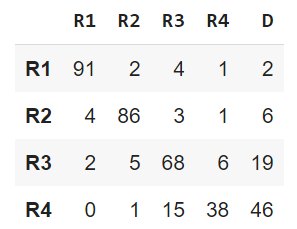

Предполагая постоянство матрицы переходных вероятностей во времени, определите вероятность дефолта заемщика с начальным рейтингом R2 в течение двух лет.

a.
12.00%

b.
12.27%

c.
13.03%

d.
11.76%

In [ ]:
# Место для кода

import numpy as np
import pandas as pd

# Пример статистика по переходам
#M = pd.DataFrame(np.array([[91, 2, 4, 1, 2], [4, 86, 3, 1, 6], [2, 5, 68, 6, 19], [0, 1, 15, 38, 46]]), index=grades1, columns=grades)
M1 = np.array([[91, 2, 4, 1, 2], [4, 86, 3, 1, 6], [2, 5, 68, 6, 19], [0, 1, 15, 38, 46]])
display(M1)

array([[91,  2,  4,  1,  2],
       [ 4, 86,  3,  1,  6],
       [ 2,  5, 68,  6, 19],
       [ 0,  1, 15, 38, 46]])

In [ ]:
# Определим вероятности дефолтов
pds = M1[:, -1]/M1.sum(axis = 1) #
print('PD для рейтинговых категорий:\n',pds,'\n')

pss = 1 - pds #вектор вероятностей выжить в конце периода h
P_tmp1 = np.concatenate((M1[:,:4]/M1[:,:4].sum(axis = 1).reshape([4,1])*pss.reshape([4,1]), pds.reshape([4,1])), axis = 1) #объединяем с вероятностями дефолтов
P1 = np.concatenate((P_tmp1,np.array([[0,0,0,0,1]])), axis = 0)

print('Оценка матрицы P1:\n')
display(pd.DataFrame(P1, index = ['R1', 'R2', 'R3', 'R4', 'D'], columns = ['R1', 'R2', 'R3', 'R4', 'D']))

PD для рейтинговых категорий:
 [0.02 0.06 0.19 0.46] 

Оценка матрицы P1:



,R1,R2,R3,R4,D
R1,0.91,0.02,0.04,0.01,0.02
R2,0.04,0.86,0.03,0.01,0.06
R3,0.02,0.05,0.68,0.06,0.19
R4,0.00,0.01,0.15,0.38,0.46
D,0.00,0.00,0.00,0.00,1.00


In [ ]:
# Возведение матрицы в степень m, позволяет вычислять матрица переходных вероятностей на горизонте m*h

# Для двух лет
P_2h1 = P1@P1
print('Матрица на два года:\n', pd.DataFrame(P_2h1).values, '\n')

# Для произвольного m
m = 5
P_mh1 = np.linalg.matrix_power(P1, m)
print('Матрица на m лет:\n', P_mh, '\n')

Матрица на два года:
 [[0.8297 0.0375 0.0657 0.0155 0.0516]
 [0.0714 0.742  0.0493 0.0146 0.1227]
 [0.0338 0.078  0.4737 0.0643 0.3502]
 [0.0034 0.0199 0.1593 0.1535 0.6639]
 [0.     0.     0.     0.     1.    ]] 

Матрица на m лет:
 [[0.63532508 0.07392449 0.09383388 0.02057874 0.17633781]
 [0.12731529 0.48514435 0.06940791 0.01732355 0.3008089 ]
 [0.05406578 0.09719144 0.17489011 0.03187102 0.64198165]
 [0.01247204 0.0317214  0.07519923 0.01944868 0.86115865]
 [0.         0.         0.         0.         1.        ]] 



In [ ]:
print(0.0034 + 0.0199 + 0.1593)

0.18259999999999998


Дана следующая таблица переходов рейтингов с начала на конец однолетнего периода.
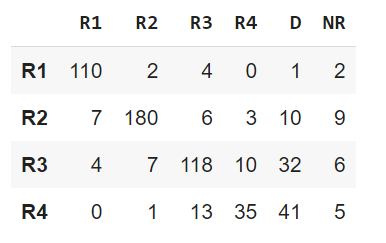

NR означает, что рейтинг заемщика был отозван в течение периода и рейтинговая категория на конец периода не известна. Также известно, что NR не меняют условные вероятности переходов из рейтинга в рейтинг.
Чему равны переходные вероятности для рейтинга R3, построенные по этим данным?

a.
R1: 2.26%, R2: 3.95% R3: 66.67% R4: 5.65% D: 18.08%

b.
R1: 2.88%, R2: 5.04% R3: 84.89.% R4: 7.19% D: 18.08%

c.
R1: 2.36%, R2: 4.13% R3: 69.54% R4: 5.89% D: 18.08%

d.
R1: 3.42%, R2: 2.92% R3: 69.54% R4: 15.08% D: 0%

In [ ]:
# Место для кода

import numpy as np
import pandas as pd

k = 2
grades2 = ['R1', 'R2', 'R3', 'R4', 'D', 'NR']
grades3 = ['R1', 'R2', 'R3', 'R4']

# Пример статистика по переходам
M = np.array([[110, 2, 4, 0, 1, 2], [7,180,6,3,10,9], [4,7,118,10,32,6], [0, 1, 13, 35, 41, 5]])
display(M)

array([[110,   2,   4,   0,   1,   2],
       [  7, 180,   6,   3,  10,   9],
       [  4,   7, 118,  10,  32,   6],
       [  0,   1,  13,  35,  41,   5]])

In [ ]:
# Определим вероятности дефолтов
pds = M[:, -2]/M.sum(axis = 1) #
print('PD для рейтинговых категорий:\n',pds,'\n')

pss = 1 - pds #вектор вероятностей выжить в конце периода h
P_tmp = np.concatenate((M[:,:4]/M[:,:4].sum(axis = 1).reshape([4,1])*pss.reshape([4,1]), pds.reshape([4,1])), axis = 1) #объединяем с вероятностями дефолтов
P = np.concatenate((P_tmp,np.array([[0,0,0,0,1]])), axis = 0)

print('Оценка матрицы P:\n')
display(pd.DataFrame(P, index = ['R1', 'R2', 'R3', 'R4', 'D'], columns = ['R1', 'R2', 'R3', 'R4', 'D']))

PD для рейтинговых категорий:
 [0.00840336 0.04651163 0.18079096 0.43157895] 

Оценка матрицы P:



,R1,R2,R3,R4,D
R1,0.940307,0.017096,0.034193,0.000000,0.008403
R2,0.034053,0.875653,0.029188,0.014594,0.046512
R3,0.023574,0.041255,0.695444,0.058936,0.180791
R4,0.000000,0.011600,0.150806,0.406015,0.431579
D,0.000000,0.000000,0.000000,0.000000,1.000000


In [ ]:
# Возведение матрицы в степень m, позволяет вычислять матрица переходных вероятностей на горизонте m*h

# Для двух лет
P_2h = P@P
print('Матрица на два года:\n', pd.DataFrame(P_2h).values, '\n')

# Для произвольного m
m = 5
P_mh = np.linalg.matrix_power(P, m)
print('Матрица на m лет:\n', P_mh, '\n')

In [ ]:
print(0.028535*100,	0.048017*100,	0.695444*100,	0.040894*100,	0.180791*100)


2.8535 4.801699999999999 69.5444 4.0894 18.0791


In [ ]:
# Возведение матрицы в степень m, позволяет вычислять матрица переходных вероятностей на горизонте m*h

# Для двух лет
P_2h2 = P@P1
print('Матрица на два года:\n', pd.DataFrame(P_2h2).values, '\n')

Матрица на два года:
 [[0.85704723 0.03521878 0.06137641 0.01162562 0.03473196]
 [0.06659824 0.75534765 0.04966896 0.01639416 0.11199098]
 [0.03701175 0.07131244 0.48392269 0.06477056 0.34298256]
 [0.00348013 0.0215768  0.16379807 0.16345005 0.64769495]
 [0.         0.         0.         0.         1.        ]] 



### 3.2.2 Непрерывная модель

Смена рейтинга и дефолт могут произойти в любой момент. Интенсивности смены рейтинга постоянны на рассматриваемом горизонте и зависят только от текущего значения рейтинга.

Основной объект в такой модели матрица интенсивностей (генератор): $$G = \{\lambda_{ij}\}_{(k+1,k+1)}$$ $$\lambda_{ij}\geq 0, i\neq j$$ $$\lambda_{ii} = -\sum_{j\neq i} \lambda_{ij}$$

Интерпретация $\lambda_{ii}$ - интенсивность выбития заемщиков рейтинга i, $\lambda_{ij}$ - интенсивность пополнения рейтинга j за счет заемщиков из рейтинга i.

Для такой модели:
$$P(h) = exp(G\cdot h) = \sum_{n = 0,\ldots, \infty } \frac{(G\cdot h)^n}{n!},$$
где $exp$ - оператор матричной экспоненты.

Оценка матрицы:
$$\bar{\lambda_{ij}} = \frac{N_{ij}}{T_i},$$

где $N_{ij}$ - количество прямых переходов из $i$ в $j$ (т.е. смены в какой-то момент времени рейтинга $i$ на рейтинг $j$);

$T_i$ - общее количество времени, выраженное, скажем, в годах, которое заемщики в совокупности провели в рейтинге $i$.

Как представлять данные:

| Rating from/ to | R1 | R2  | D |
|:-------|:-------|:-------|:-------|
| **R1**| 2.45 | 1 | 0 |
|**R2** | 4 | 3.45 | 12|

На главное диагонали находится календартное время проведенное всеми заемщиками в рейтинговой категории ($T_2 = 3.45$ года)

На неглавной диагонали - прямые переходы между рейтингами ($N_{12} = $1, то есть один заемщик непосредственно перешел из R1 в R2)



In [ ]:
# Место для кода
import scipy.linalg as la

# Зададим матрицу генератор
G = np.array([[-.8, 0.7, 0.1],[0.4, -0.7, 0.3],[0, 0, 0]])
print('Матрица генератор G \n',G,'\nОбратите внимаине на последнюю строку - она состоит из нулей!')

# Зададим некоторый горизонг
h = 1.5
print('\nМатрица переходных вероятностей на горизонте h:\n',la.expm(G*h))

Матрица генератор G 
 [[-0.8  0.7  0.1]
 [ 0.4 -0.7  0.3]
 [ 0.   0.   0. ]] 
Обратите внимаине на последнюю строку - она состоит из нулей!

Матрица переходных вероятностей на горизонте h:
 [[0.40640181 0.37816283 0.21543536]
 [0.21609305 0.46042507 0.32348188]
 [0.         0.         1.        ]]


In [ ]:
N = np.array([[0,2,5,0,1], [6,0,5,3,6], [5,9,0,18,30], [0,0,42,0,98]])
T = [100,120,150,140]
S = np.array([[100,2,5,0,1], [6,120,5,3,6], [5,9,150,18,30], [0,0,42,140,98]])
display(pd.DataFrame(N, index = ['R1', 'R2', 'R3', 'R4'], columns = ['R1', 'R2', 'R3', 'R4', 'D']))
display(pd.DataFrame(T, index = ['R1', 'R2', 'R3', 'R4'], columns = ['Лет']))
display(pd.DataFrame(S, index = ['R1', 'R2', 'R3', 'R4'], columns = ['R1', 'R2', 'R3', 'R4', 'D']))

,R1,R2,R3,R4,D
R1,0,2,5,0,1
R2,6,0,5,3,6
R3,5,9,0,18,30
R4,0,0,41,0,98


,Лет
R1,100
R2,120
R3,150
R4,140


,R1,R2,R3,R4,D
R1,100,2,5,0,1
R2,6,120,5,3,6
R3,5,9,150,18,30
R4,0,0,41,140,98


In [ ]:
# Место для кода
import scipy.linalg as la

# Зададим матрицу генератор
#G = np.array([[1, 0.02, 0.033, 0],[0.02, 1, 0.06, 0],[0.05, 0.042, 1, 0.292], [0, 0.025, 0.12, 1], [0, 0, 0, 0]])
G = np.array([[-0.08, 0.02, 0.05, 0, 0.01],[0.05, -0.167, 0.042, 0.025, 0.05],[0.033, 0.06, -0.413, 0.12, 0.2], [0, 0, 0.3, -1, 0.7], [0,0, 0, 0, 0]])
print('Матрица генератор G \n',G,'\nОбратите внимаине на последнюю строку - она состоит из нулей!')

# Зададим некоторый горизонт
h = 2.5
print('\nМатрица переходных вероятностей на горизонте h:\n',la.expm(G*h))

Матрица генератор G 
 [[-0.08   0.02   0.05   0.     0.01 ]
 [ 0.05  -0.167  0.042  0.025  0.05 ]
 [ 0.033  0.06  -0.413  0.12   0.2  ]
 [ 0.     0.     0.3   -1.     0.7  ]
 [ 0.     0.     0.     0.     0.   ]] 
Обратите внимаине на последнюю строку - она состоит из нулей!

Матрица переходных вероятностей на горизонте h:
 [[0.82472561 0.04254661 0.07310599 0.00693591 0.05268588]
 [0.09525807 0.66595688 0.06482951 0.02292285 0.15103269]
 [0.05269334 0.07720357 0.38926252 0.05993783 0.42090274]
 [0.01101078 0.01700205 0.14630248 0.09878191 0.72690278]
 [0.         0.         0.         0.         1.        ]]


In [ ]:

print(np.array([[-0.08, 0.02, 0.05, 0, 0.01],[0.05, -0.167, 0.042, 0.025, 0.05],[0.033, 0.06, -0.413, 0.12, 0.2], [0, 0, 0.3, -1, 0.7], [0, 0, 0, 0, 0]]))


[[-0.08   0.02   0.05   0.     0.01 ]
 [ 0.05  -0.167  0.042  0.025  0.05 ]
 [ 0.033  0.06  -0.413  0.12   0.2  ]
 [ 0.     0.     0.3   -1.     0.7  ]
 [ 0.     0.     0.     0.     0.   ]]


# Работа с историческиим периодами
- матрицы переходных вероятностей меняются во времени
   - имеет значение фаза экономического цикла
- как они меняются зависит от свойств рейтинговых систем
 - PIT (point-in-time) - оценивает краткосрочный риск (вероятности переходов меняются с фазой экономического цикла, PD стабильны)
 - TTC (through-the-cycle) - оценивает долгосрочный риск (вероятности переходов стабильны, PD меняются с фазой экономического цикла)
- в первом предположении можно считать, что матрица переходных вероятностей локально постоянна (например, в течение года)
 - разбиваем исторические данные по годам оцениваем матрицу за каждый год, потом перемножаем, чтобы получить оценку матрицы за n лет
 - (!!!) это не то же самое, что вычислить среднюю годовую матрицу по данным за пять лет
 - когда матрицы переходных вероятностей в разные годы различаются, важно не перепутать порядок умножения, т.к. от этого зависит результирующая матрица.


Чему будет равна интенсивность перехода из рейтинга R2 в R3, если в данных из Задания 5 о переходах и времени дополнительно учесть заемщика, который провел полгода с рейтингом R1, сменил его на рейтинг R2, после чего прожил с R2 еще четыре года.

In [ ]:
N = np.array([[0,3,5,0,1], [6,0,5,3,6], [5,9,0,18,30], [0,0,42,0,98]])
T = [100.5,124,150,140]
S = np.array([[100,2,5,0,1], [6,120,5,3,6], [5,9,150,18,30], [0,0,42,140,98]])
display(pd.DataFrame(N, index = ['R1', 'R2', 'R3', 'R4'], columns = ['R1', 'R2', 'R3', 'R4', 'D']))
display(pd.DataFrame(T, index = ['R1', 'R2', 'R3', 'R4'], columns = ['Лет']))
display(pd.DataFrame(S, index = ['R1', 'R2', 'R3', 'R4'], columns = ['R1', 'R2', 'R3', 'R4', 'D']))

,R1,R2,R3,R4,D
R1,0,2,5,0,1
R2,6,0,5,3,6
R3,5,9,0,18,30
R4,0,0,42,0,98


,Лет
R1,100
R2,120
R3,150
R4,140


,R1,R2,R3,R4,D
R1,100,2,5,0,1
R2,6,120,5,3,6
R3,5,9,150,18,30
R4,0,0,42,140,98


In [ ]:
# Место для кода
import scipy.linalg as la

# Зададим матрицу генератор
#G = np.array([[1, 0.02, 0.033, 0],[0.02, 1, 0.06, 0],[0.05, 0.042, 1, 0.292], [0, 0.025, 0.12, 1], [0, 0, 0, 0]])
G = np.array([[-0.08, 0.02, 0.05, 0, 0.01],[0.05, -0.167, 0.042, 0.025, 0.05],[0.033, 0.06, -0.413, 0.12, 0.2], [0, 0, 0.3, -1, 0.7], [0,0, 0, 0, 0]])
print('Матрица генератор G \n',G,'\nОбратите внимаине на последнюю строку - она состоит из нулей!')

# Зададим некоторый горизонт
h = 2.5
print('\nМатрица переходных вероятностей на горизонте h:\n',la.expm(G*h))

Матрица генератор G 
 [[-0.08   0.02   0.05   0.     0.01 ]
 [ 0.05  -0.167  0.042  0.025  0.05 ]
 [ 0.033  0.06  -0.413  0.12   0.2  ]
 [ 0.     0.     0.3   -1.     0.7  ]
 [ 0.     0.     0.     0.     0.   ]] 
Обратите внимаине на последнюю строку - она состоит из нулей!

Матрица переходных вероятностей на горизонте h:
 [[0.82472561 0.04254661 0.07310599 0.00693591 0.05268588]
 [0.09525807 0.66595688 0.06482951 0.02292285 0.15103269]
 [0.05269334 0.07720357 0.38926252 0.05993783 0.42090274]
 [0.01101078 0.01700205 0.14630248 0.09878191 0.72690278]
 [0.         0.         0.         0.         1.        ]]


In [ ]:

print(np.array([[-0.08, 0.02, 0.05, 0, 0.01],[0.05, -0.167, 0.042, 0.025, 0.05],[0.033, 0.06, -0.413, 0.12, 0.2], [0, 0, 0.3, -1, 0.7], [0, 0, 0, 0, 0]]))


[[-0.08   0.02   0.05   0.     0.01 ]
 [ 0.05  -0.167  0.042  0.025  0.05 ]
 [ 0.033  0.06  -0.413  0.12   0.2  ]
 [ 0.     0.     0.3   -1.     0.7  ]
 [ 0.     0.     0.     0.     0.   ]]
